# 1. 사진 준비하기
- OpenCV로 이미지를 읽어와서 resize하고 RGB 이미지로 바꾸어 출력한다.

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


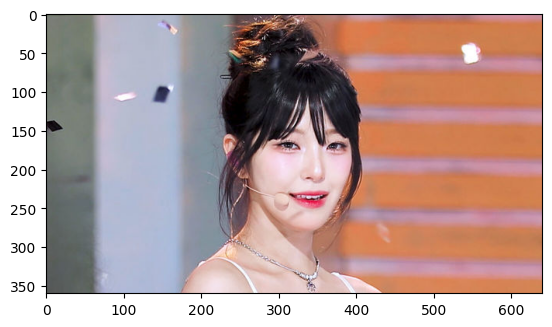

In [103]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = "/content/drive/MyDrive/영훈고/camera_sticker_app/bjh.jpg"
img_bgr = cv2.imread(my_image_path)  # OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # Resize
img_show = img_bgr.copy()      # 출력용 이미지 별도 카피/
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # RGB 이미지로 변경
plt.imshow(img_rgb)
plt.show()

- `cv2.imread('img.png', flag)`: 이미지를 읽을 때 flag를 설정할 수 있다. 다음 순서대로 1, 0, -1의 값을 가지며 default는 0이다.
    - cv2.IMREAD_COLOR: 이미지 파일을 Color로 읽어들이기, 투명한 부분은 무시
    - cv2.IMREAD_GRAYSCALE: 이미지를 Grayscale로 읽어들이기, 실제 이미지 처리시 중간단계로 많이 사용
    - cv2.IMREAD_UNCHANGED: 이미지파일을 alpha channel까지 포함하여 읽어들임
- `cv2.resize(img, size)`: 원본 이미지 비율에 맞게 축소(640x360 (16:9), 640x480 (4:3))
- `cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`: opencv는 예외적으로 RGB가 아닌 BGR(파랑, 녹색, 빨강)를 사용한다. 그래서 원본 사진을 불러오면 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력된다. opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 RGB 이미지로 바꿔야 한다.

***
# 2. Face Detection

- dlib의 face detector는 **HOG**(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는다.
    - 그래디언트(gradient)를 특징(feature)으로 사용: 동일한 오브젝트라도 밝을 때와 어두울 때의 픽셀값의 분포는 완전히 다르다. 따라서 픽셀의 RGB값 자체보다는 밝기가 변하는 방향(그래디언트)을 고려하면 주변 상황과 무관하게 동일한 표현(representation)을 얻을 수 있다.
    - 단일 픽셀의 그래디언트가 아닌 16x16 의 정사각형을 사용: 이미지의 기본 패턴을 알려면 단일 픽셀보다는 높은 수준에서 명암의 기본 흐름을 보는 것이 더 좋다.

rectangles[[(282, 139) (411, 268)]]


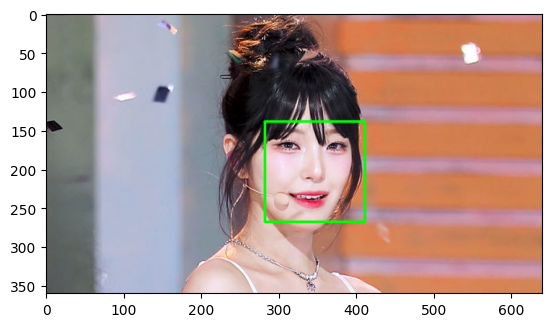

In [105]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   # dlib을 활용해 hog detector를 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # dlib은 rgb 이미지를 입력으로 받음
dlib_rects = detector_hog(img_rgb, 1)   # detector를 이용해서 얼굴의 bounding box를 추출

print(dlib_rects)   # 얼굴 영역 좌표 출력

# 이미지 위에 얼굴의 bounding box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- `detector_hog(img, num of img pyramid)`:
    - 동일 이미지의 서로 다른 사이즈의 set을 이미지 피라미드라고 한다. 이미지를 upsampling 방법을 통해 크기를 키우고 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.
    - dlib detector는 dlib.rectangles 타입의 객체를 반환하고, dlib.rectangles는 dlib.rectangle 객체의 배열 형태로 이루어져 있다. lib.rectangle 객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함하고 있다.

***
# 3. Face Landmark

- **Face landmark localization**: detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지에서 이목구비의 위치를 찾아내는 기술
- **Object keypoint estimation**: Face landmark와 같이 객체 내부의 점을 찾는 기술(본 예제에서는 1번 방식을 다룸)
    - top-down : bounding box를 찾고 box 내부의 keypoint를 예측
    - bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

- **Dlib landmark localization**: Dlib에서 제공하는 ibug 300-W 데이터셋으로 학습한 pretrained model 사용하며, 잘라진 얼굴 이미지에서 68개의 이목구비 위치를 찾아냄

In [106]:
import os
import urllib.request

# 실행 경로 가져오기
current_path = os.getcwd()

# 다운로드 URL
model_url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"

# 현재 실행 경로에 다운로드
model_path = os.path.join(current_path, "shape_predictor_68_face_landmarks.dat.bz2")

# 모델 다운로드
urllib.request.urlretrieve(model_url, model_path)
print(f"모델 다운로드 완료: {model_path}")

# 압축 해제
import bz2
extracted_model_path = model_path[:-4]  # ".bz2" 확장자 제거
with bz2.BZ2File(model_path) as f_in, open(extracted_model_path, 'wb') as f_out:
    f_out.write(f_in.read())

# 압축 해제 완료
print(f"압축 해제 완료: {extracted_model_path}")

# 압축 파일 삭제 (선택 사항)
os.remove(model_path)
print("압축 파일 삭제 완료.")

모델 다운로드 완료: /content/shape_predictor_68_face_landmarks.dat.bz2
압축 해제 완료: /content/shape_predictor_68_face_landmarks.dat
압축 파일 삭제 완료.


In [107]:
# landmark 모델을 불러오기
model_path = "/content/shape_predictor_68_face_landmarks.dat"
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 개별 위치 저장
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))   # 68개의 (x,y) 튜플로 이루어진 리스트

68


- `landmark_predictor(img_rgb, dlib_rect)`: RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection를 반환
- `points.parts()`: dlib.full_object_detection의 객체이므로 parts() 함수로 개별 위치에 접근 가능(lambda 함수를 사용해 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환)
- `list_points`: tuple (x, y) 68개로 이루어진 리스트로, 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됨

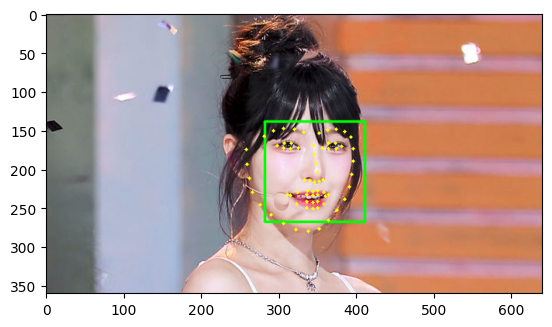

In [108]:
# 이미지에 landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

***
# 4. 스티커 적용하기

- 랜드마크를 기준으로 스티커를 붙일 위치와 스티커의 크기를 계산한다.
- 얼굴 위치, 카메라의 거리에 따라 픽셀 x가 다르기 때문에 비율로 계산을 해줘야 한다.

## 4-1. 스티커 위치 및 크기 계산

In [109]:
# for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
#     print (landmark[30]) # 코의 중심점 좌표 확인(nose center index: 30)
#     x = landmark[30][0]
#     y = landmark[30][1] - dlib_rect.width()//2
#     w = dlib_rect.width()
#     h = dlib_rect.width()
#     print ('(x,y) : (%d,%d)'%(x,y))  # 스티커의 위치 (x,y)
#     print ('(w,h) : (%d,%d)'%(w,h))  # 스티커의 크기 (w,h)


for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # 눈썹 좌표 (왼쪽 눈썹: 17~21, 오른쪽 눈썹: 22~26)
    left_eyebrow = landmark[17:22]  # 왼쪽 눈썹 좌표 리스트
    right_eyebrow = landmark[22:27]  # 오른쪽 눈썹 좌표 리스트

    # 눈썹 중심점 계산
    left_eyebrow_center = np.mean(left_eyebrow, axis=0).astype(int)  # 왼쪽 눈썹 중심
    right_eyebrow_center = np.mean(right_eyebrow, axis=0).astype(int)  # 오른쪽 눈썹 중심

    # 스티커의 중심은 왼쪽과 오른쪽 눈썹 중심의 평균
    x = int((left_eyebrow_center[0] + right_eyebrow_center[0]) / 2)
    y = int((left_eyebrow_center[1] + right_eyebrow_center[1]) / 2)

    # 스티커 크기 설정 (얼굴 너비에 비례)
    w = dlib_rect.width()
    h = dlib_rect.width()

    print(f"(x, y): ({x}, {y})")  # 스티커의 중심 좌표
    print(f"(w, h): ({w}, {h})")  # 스티커의 크기

(x, y): (339, 151)
(w, h): (130, 130)


## 4-2. 스티커 resize & 좌표 조정

In [110]:
# 스티커 이미지를 읽어와 윗 단계에서 계산한 크기로 resize
sticker_path = "/content/drive/MyDrive/영훈고/camera_sticker_app/crown.png"
img_sticker = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(130, 130, 4)


In [111]:
# 눈썹 좌표를 사용하여 스티커의 중심 계산
refined_x = x - w // 2  # 스티커 중심을 x 축 기준으로 맞춤
refined_y = y - h       # 눈썹 바로 위에 스티커를 배치

# 추가적으로 스티커 위치를 눈썹 위로 살짝 이동
refined_y -= 10  # 눈썹 위로 10 픽셀 더 올림 (필요시 값 조정 가능)

# 원본 이미지 경계 처리를 개선
if refined_x < 0:  # 왼쪽 경계 초과
    img_sticker = img_sticker[:, -refined_x:]  # 왼쪽 초과 부분을 자름
    refined_x = 0  # x 좌표를 경계로 설정

if refined_y < 0:  # 위쪽 경계 초과
    img_sticker = img_sticker[-refined_y:, :]  # 위쪽 초과 부분을 자름
    refined_y = 0  # y 좌표를 경계로 설정

# 스티커가 이미지 오른쪽이나 아래쪽을 초과할 경우 처리 (옵션)
if refined_x + img_sticker.shape[1] > img_bgr.shape[1]:  # 오른쪽 경계 초과
    img_sticker = img_sticker[:, :img_bgr.shape[1] - refined_x]

if refined_y + img_sticker.shape[0] > img_bgr.shape[0]:  # 아래쪽 경계 초과
    img_sticker = img_sticker[:img_bgr.shape[0] - refined_y, :]

In [112]:

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (274,11)


## 4-3. 스티커 적용

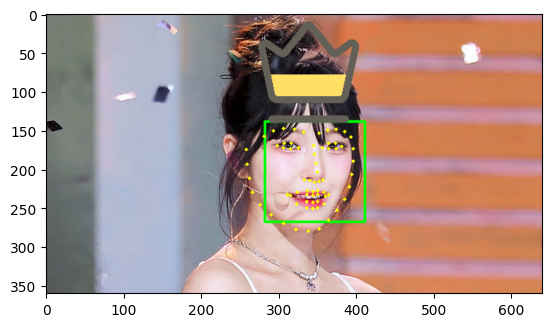

In [113]:
# 스티커의 알파 채널 분리 (투명도)
sticker_alpha = img_sticker[:, :, 3] / 255.0  # 알파 채널(0~255)을 0~1로 정규화
sticker_rgb = img_sticker[:, :, :3]           # RGB 채널 (알파 채널 제외)

# 관심 영역(ROI)
sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0],
                        refined_x:refined_x + img_sticker.shape[1]]

# 알파 블렌딩을 이용한 스티커 합성
for c in range(0, 3):  # B, G, R 채널 각각 처리
    sticker_area[:, :, c] = (
        sticker_alpha * sticker_rgb[:, :, c] +  # 스티커의 색상
        (1 - sticker_alpha) * sticker_area[:, :, c]  # 원본 이미지 유지
    ).astype(np.uint8)

# 합성된 스티커를 원본 이미지에 적용
img_show[refined_y:refined_y + img_sticker.shape[0],
         refined_x:refined_x + img_sticker.shape[1]] = sticker_area

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- `sticker_area`: 원본 이미지에서 스티커를 적용할 위치를 crop한 이미지로, 예제에서는 (237,0)부터 (237+187, 0+134) 범위의 이미지를 의미
- 스티커 이미지에서 0 이 아닌 색이 있는 부분만 사용한다. `np.where()`를 통해 img_sticker가 0인 부분은 sticker_area를 사용하고, 0이 아닌 부분은 img_sticker를 사용한다.

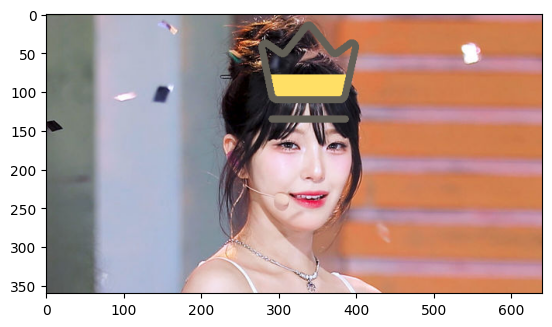

In [114]:
# 스티커의 RGB와 알파 채널 분리
sticker_rgb = img_sticker[:, :, :3]  # RGB 채널
sticker_alpha = img_sticker[:, :, 3] / 255.0  # 알파 채널 (0~1로 정규화)

# 관심 영역(ROI)
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0],
                       refined_x:refined_x + img_sticker.shape[1]]

# 알파 채널을 이용한 블렌딩
for c in range(3):  # B, G, R 채널 각각 처리
    sticker_area[:, :, c] = (
        sticker_alpha * sticker_rgb[:, :, c] +  # 스티커의 색상
        (1 - sticker_alpha) * sticker_area[:, :, c]  # 원본 이미지 유지
    ).astype(np.uint8)

# 최종 결과 이미지를 업데이트
img_bgr[refined_y:refined_y + img_sticker.shape[0],
        refined_x:refined_x + img_sticker.shape[1]] = sticker_area

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()